In [1]:
import pandas as pd
from sklearn import linear_model
import numpy as np
from matplotlib import pyplot as plt
import ants
import os
from tqdm import tqdm
import statistics
import statsmodels.api as sm

In [2]:
cd ../../Data/Genemaps

/mmfs1/data/pijarj/BC-ORG-Data/Data/Genemaps


In [3]:
#read in symptom patient data and slice out important columns
df = pd.read_csv('/mmfs1/data/pijarj/Data4Julianna/df_patients_S699.csv')
df.columns
df[['ados_total', 'ados_comm', 'ados_social', 'ados_rrb']]

,ados_total,ados_comm,ados_social,ados_rrb
0,18.0,6.0,12.0,2.0
1,NaN,NaN,NaN,NaN
2,13.0,4.0,9.0,NaN
3,12.0,4.0,8.0,2.0
4,16.0,5.0,11.0,3.0
...,...,...,...,...
694,NaN,NaN,NaN,NaN
695,NaN,NaN,NaN,NaN
696,13.0,4.0,9.0,2.0
697,8.0,2.0,6.0,2.0


In [4]:
#load in diffmat data
atlas = ants.image_read('/mmfs1/data/pijarj/BC-ORG-Data/YeoAtlas/Atlas_parc-7n_2mm.nii')
diffmat = np.load('/mmfs1/data/pijarj/Data4Julianna/recon_asd_mu.npz')
diffmat = diffmat['data']
diffmat.shape

(699, 51, 51)

In [5]:
genemaps = [file for file in os.listdir() if file.endswith('.nii.gz')]
genemaps.sort()

In [6]:
nsubjects = 699
ngenes = len(genemaps)
print(nsubjects)
print(ngenes)

gene_fmri_corr = np.zeros((ngenes,nsubjects))
gene_fmri_corr

699
122


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [7]:
for g in tqdm(range(ngenes)):
    gene_im = ants.image_read(genemaps[g])
    gene_flat = gene_im.numpy().flatten()
    atlas_flat = atlas.numpy().flatten()
    roi_expression = np.array([gene_flat[atlas_flat==roi].mean() for roi in np.arange(1,52)])
    gene_sim = np.zeros((51,51))
    for i in range(51):
        for j in range(51):
            gene_sim[i,j] = abs(roi_expression[i]-roi_expression[j])

    triu = np.triu_indices(51,k=1)
    gene_vec = gene_sim[triu]

    for s in range(nsubjects):
        subject_diffmat = diffmat[s,:,:] # correlation matrices for one subject
        fmri_vec = subject_diffmat[triu]
        data = np.corrcoef(gene_vec,fmri_vec)[0,1]
        gene_fmri_corr[g,s] = data

100%|██████████| 122/122 [00:12<00:00,  9.84it/s]


(122, 699)

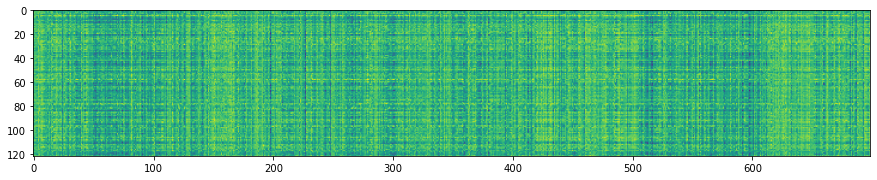

In [8]:
plt.figure(figsize=(15,10))
plt.imshow(gene_fmri_corr)
gene_fmri_corr.shape

In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
principalComponents = pca.fit_transform(gene_fmri_corr.transpose())
gene_fmri_corr_PCA = principalComponents.transpose()

In [10]:
principalComponents.shape

(699, 10)

In [11]:
gene_fmri_corr_PCA.shape

(10, 699)

In [50]:
col_id = 0
Y_total = df[['ados_total', 'ados_comm', 'ados_social', 'ados_rrb']].values
column_total = (['ados_total', 'ados_comm', 'ados_social', 'ados_rrb'][col_id])
good_subjects_total = ~np.isnan(Y_total)[:,col_id]
Y_use_total = Y_total[good_subjects_total,col_id] 
X_use_total = gene_fmri_corr_PCA[:,good_subjects_total]
X_use_total = X_use_total.transpose()
regression_total =  linear_model.LinearRegression(normalize=True)
linear_regression_total = regression_total.fit(X_use_total,Y_use_total) 
Y_use_hat_total = linear_regression_total.predict(X_use_total)

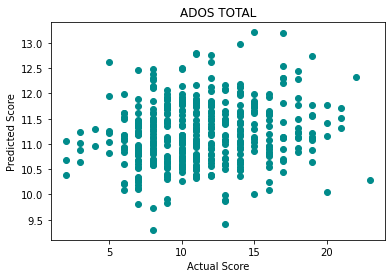

In [51]:
#scatter plot for ados_total
plt.scatter(Y_use_total,Y_use_hat_total,color='darkcyan')
plt.title('ADOS TOTAL')
plt.xlabel('Actual Score')
plt.ylabel('Predicted Score')
plt.show()

In [52]:
col_id = 1
Y_comm = df[['ados_total', 'ados_comm', 'ados_social', 'ados_rrb']].values
column_comm = (['ados_total', 'ados_comm', 'ados_social', 'ados_rrb'][col_id])
good_subjects_comm = ~np.isnan(Y_comm)[:,col_id]
Y_use_comm = Y_comm[good_subjects_comm,col_id] 
X_use_comm = gene_fmri_corr_PCA[:,good_subjects_comm]
X_use_comm = X_use_comm.transpose()
regression_comm =  linear_model.LinearRegression(normalize=True)
linear_regression_comm = regression_comm.fit(X_use_comm,Y_use_comm) 
Y_use_hat_comm = linear_regression_comm.predict(X_use_comm)

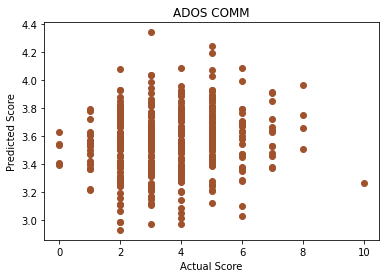

In [53]:
#scatter plot for ados_comm
plt.scatter(Y_use_comm,Y_use_hat_comm,color='sienna')
plt.title('ADOS COMM')
plt.xlabel('Actual Score')
plt.ylabel('Predicted Score')
plt.show()

In [54]:
col_id = 2
Y_social = df[['ados_total', 'ados_comm', 'ados_social', 'ados_rrb']].values
column_social = (['ados_total', 'ados_comm', 'ados_social', 'ados_rrb'][col_id])
good_subjects_social = ~np.isnan(Y_social)[:,col_id]
Y_use_social = Y_social[good_subjects_social,col_id] 
X_use_social = gene_fmri_corr_PCA[:,good_subjects_social]
X_use_social = X_use_social.transpose()
regression_social =  linear_model.LinearRegression(normalize=True)
linear_regression_social = regression_social.fit(X_use_social,Y_use_social) 
Y_use_hat_social = linear_regression_social.predict(X_use_social)

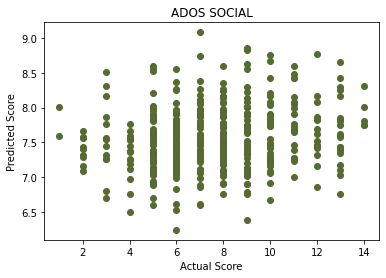

In [55]:
#scatter plot for ados_social
plt.scatter(Y_use_social,Y_use_hat_social,color='darkolivegreen')
plt.title('ADOS SOCIAL')
plt.xlabel('Actual Score')
plt.ylabel('Predicted Score')
plt.show()

In [56]:
col_id = 3
Y_rrb = df[['ados_total', 'ados_comm', 'ados_social', 'ados_rrb']].values
column_rrb = (['ados_total', 'ados_comm', 'ados_social', 'ados_rrb'][col_id])
good_subjects_rrb = ~np.isnan(Y_rrb)[:,col_id]
Y_use_rrb = Y_rrb[good_subjects_rrb,col_id] 
X_use_rrb = gene_fmri_corr_PCA[:,good_subjects_rrb]
X_use_rrb = X_use_rrb.transpose()
regression_rrb =  linear_model.LinearRegression(normalize=True)
linear_regression_rrb = regression_rrb.fit(X_use_rrb,Y_use_rrb) 
Y_use_hat_rrb = linear_regression_rrb.predict(X_use_rrb)

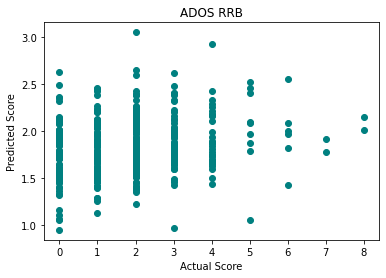

In [58]:
#scatter plot for ados_rrb
plt.scatter(Y_use_rrb,Y_use_hat_rrb,color='teal')
plt.title('ADOS RRB')
plt.xlabel('Actual Score')
plt.ylabel('Predicted Score')
plt.show()

In [59]:
#variance explained for ados_total
from sklearn.metrics import explained_variance_score
total = explained_variance_score(Y_use_total,Y_use_hat_total)*100
print(total)

2.5611846836515295


In [60]:
#variance explained for ados_comm
from sklearn.metrics import explained_variance_score
comm = explained_variance_score(Y_use_comm,Y_use_hat_comm)*100
print(comm)

2.05826839720914


In [61]:
#variance explained for ados_social
from sklearn.metrics import explained_variance_score
social = explained_variance_score(Y_use_social,Y_use_hat_social)*100
print(social)

2.8613259821980153


In [62]:
#variance explained for ados_rrb
from sklearn.metrics import explained_variance_score
rrb = explained_variance_score(Y_use_rrb,Y_use_hat_rrb)*100
print(rrb)

4.331763107024611


Text(0.5, 0, 'Symptom')

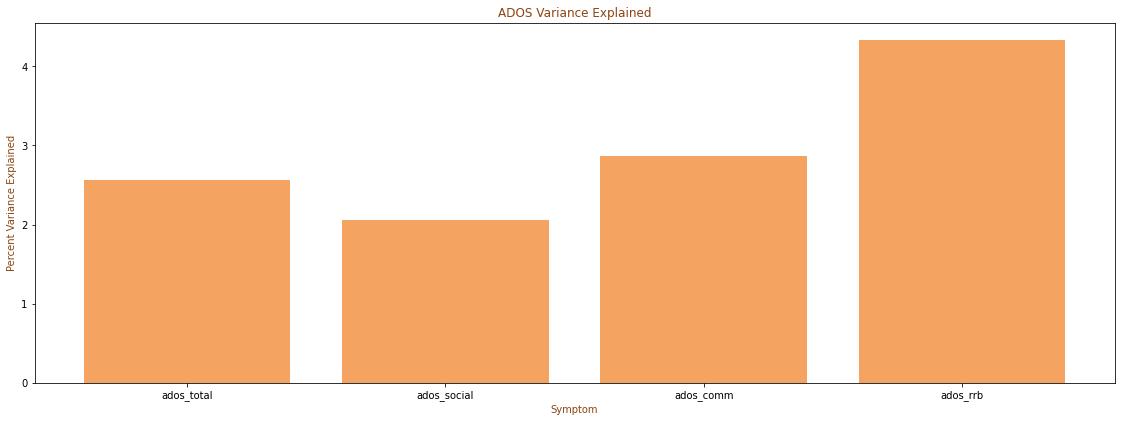

In [65]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_axes([0,0,1,1])
ados_label = ['ados_total','ados_social','ados_comm','ados_rrb']
var_explained = total, comm, social, rrb
plt.bar(ados_label,var_explained,color='sandybrown')
plt.title('ADOS Variance Explained',color='saddlebrown')
plt.ylabel('Percent Variance Explained',color='saddlebrown')
plt.xlabel('Symptom',color='saddlebrown')

In [66]:
#correlation coefficents for ados_total
coefficient_total = regression_total.coef_
labels = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10']
print(column_total)
print()
for i in range(0,10):
    print(f'{labels[i]},{coefficient_total[i]}')

ados_total

PC1,0.38214054392640723
PC2,0.30707536954615194
PC3,-0.8047251617678614
PC4,0.8390788493832547
PC5,0.7265446075558891
PC6,-0.7408607852173642
PC7,2.8391985454791713
PC8,1.3284570351834606
PC9,0.38906153362404433
PC10,-3.7374272565930853


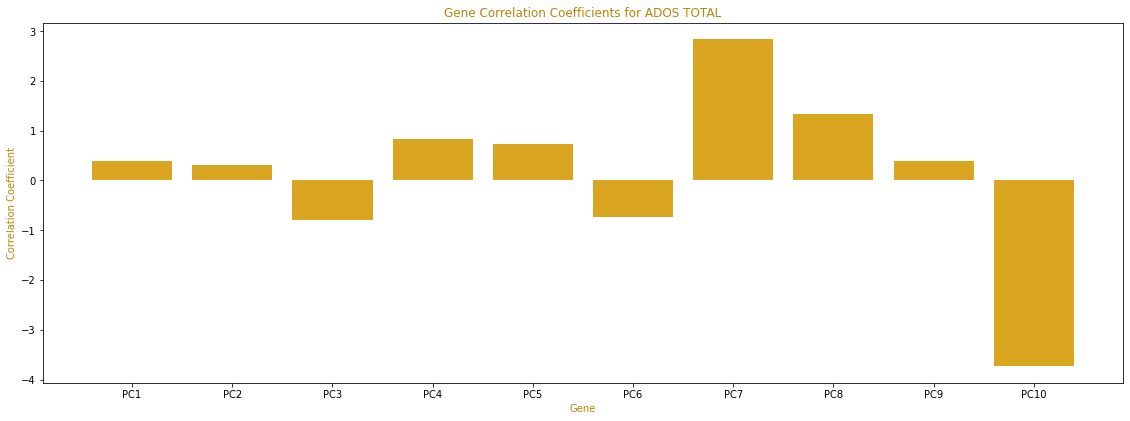

In [70]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_axes([0,0,1,1])
plt.bar(labels,coefficient_total,color='goldenrod')
plt.title('Gene Correlation Coefficients for ADOS TOTAL',color='darkgoldenrod')
plt.ylabel('Correlation Coefficient',color='darkgoldenrod')
plt.xlabel('Gene',color='darkgoldenrod')
plt.show()

In [71]:
#correlation coefficents for ados_comm
coefficient_comm = regression_comm.coef_
print(column_comm)
print()
for i in range(0,10):
    print(f'{labels[i]},{coefficient_comm[i]}')

ados_comm

PC1,-0.07504232482667686
PC2,0.18577530106055648
PC3,-0.12390477396277282
PC4,0.2559191823189382
PC5,0.39649487278983475
PC6,-0.49740657602558164
PC7,0.9378662691262147
PC8,1.075712012269086
PC9,-0.036558938017932543
PC10,-1.1701534289051359


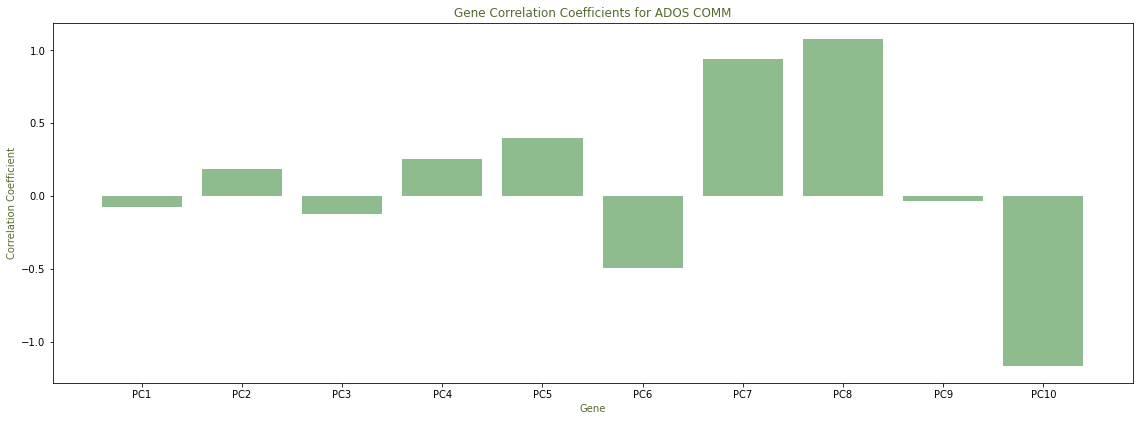

In [72]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_axes([0,0,1,1])
plt.bar(labels,coefficient_comm,color='darkseagreen')
plt.title('Gene Correlation Coefficients for ADOS COMM',color='darkolivegreen')
plt.ylabel('Correlation Coefficient',color='darkolivegreen')
plt.xlabel('Gene',color='darkolivegreen')
plt.show()

In [73]:
#correlation coefficents for ados_social
coefficient_social = regression_social.coef_
print(column_social)
print()
for i in range(0,10):
    print(f'{labels[i]},{coefficient_social[i]}')

ados_social

PC1,0.38333800097467985
PC2,-0.02223551255435384
PC3,-1.2304268631358783
PC4,0.7366563605803386
PC5,0.1548625440315409
PC6,-0.3371780775396815
PC7,1.6263988165630163
PC8,0.27782355620276844
PC9,0.07239633302466136
PC10,-2.3636273712665745


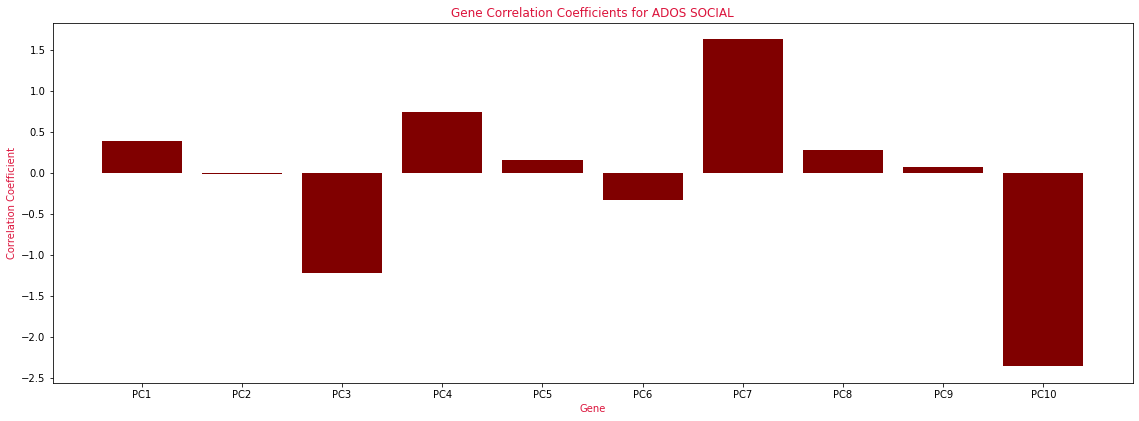

In [74]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_axes([0,0,1,1])
plt.bar(labels,coefficient_social,color='maroon')
plt.title('Gene Correlation Coefficients for ADOS SOCIAL',color='crimson')
plt.ylabel('Correlation Coefficient',color='crimson')
plt.xlabel('Gene',color='crimson')
plt.show()

In [75]:
#correlation coefficents for ados_rrb
coefficient_rrb = regression_rrb.coef_
print(column_rrb)
print()
for i in range(0,10):
    print(f'{labels[i]},{coefficient_rrb[i]}')

ados_rrb

PC1,0.15085749493426098
PC2,-0.06042027571822182
PC3,-0.8557868248113888
PC4,-0.09441900845726667
PC5,1.1626814786800916
PC6,0.6680377329321556
PC7,1.171037691973068
PC8,-0.2929780612075634
PC9,0.0695624689140198
PC10,-0.5146514820071675


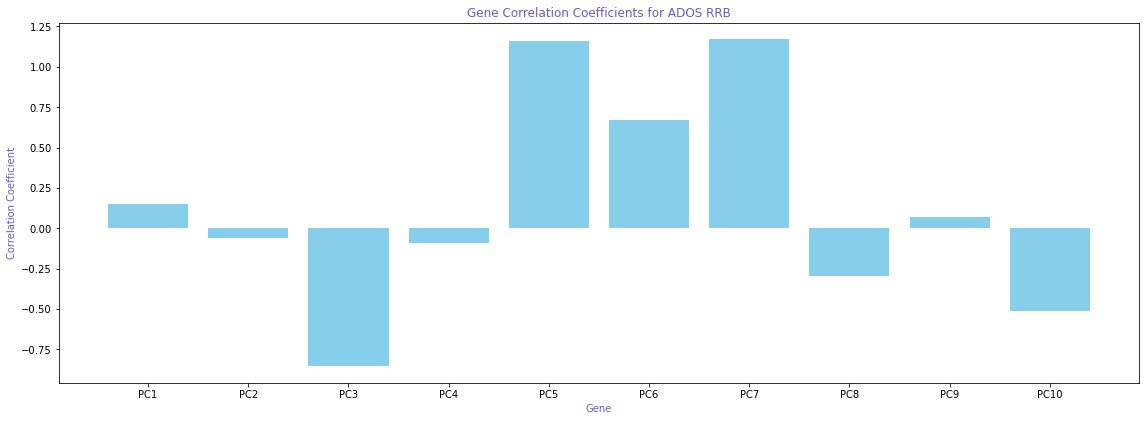

In [79]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_axes([0,0,1,1])
plt.bar(labels,coefficient_rrb,color='skyblue')
plt.title('Gene Correlation Coefficients for ADOS RRB',color='slateblue')
plt.ylabel('Correlation Coefficient',color='slateblue')
plt.xlabel('Gene',color='slateblue')
plt.show()

In [80]:
#significance of coefficients for ados_total
print('ADOS_TOTAL')
X_total = X_use_total.copy()
Y_total = Y_use_total.copy()
X_total = sm.add_constant(X_total)
print(X_total.shape)
print(Y_total.shape)

est_total = sm.OLS(Y_total, X_total)
est2_total = est_total.fit()
print(est2_total.summary())

ADOS_TOTAL
(429, 11)
(429,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.099
Date:                Mon, 28 Nov 2022   Prob (F-statistic):              0.362
Time:                        21:39:22   Log-Likelihood:                -1184.2
No. Observations:                 429   AIC:                             2390.
Df Residuals:                     418   BIC:                             2435.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.1634   

In [84]:
def plot_errorbar_from_table(est2_total,labels):
    coef_total = est2_total.params[1::]
    ci_total = est2_total.conf_int()[1::,:]
    ci_rel_total = abs(np.vstack((coef_total,coef_total)).transpose() - ci_total)
    ci_rel_total = ci_rel_total.transpose()
    xs_total = np.arange(len(coef_total))

    plt.figure(figsize=(15,5))
    plt.bar(xs_total,coef_total,color='lightskyblue')
    plt.errorbar(xs_total,coef_total,ci_rel_total,fmt='r ',capsize=10,ecolor='navy')
    plt.xticks(xs_total,labels=labels);

Text(0.5, 0, 'Gene')

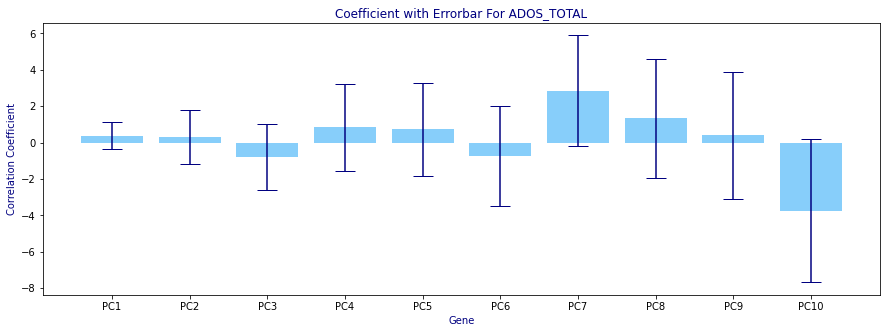

In [86]:
plot_errorbar_from_table(est2_total,labels)
plt.title('Coefficient with Errorbar For ADOS_TOTAL',color='navy')
plt.ylabel('Correlation Coefficient',color='navy')
plt.xlabel('Gene',color='navy')

In [87]:
#significance of coefficients for ados_comm
print('ADOS_COMM')
X_comm = X_use_comm.copy()
Y_comm = Y_use_comm.copy()
X_comm = sm.add_constant(X_comm)

est_comm = sm.OLS(Y_comm, X_comm)
est2_comm = est_comm.fit()
print(est2_comm.summary())

ADOS_COMM
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.8406
Date:                Mon, 28 Nov 2022   Prob (F-statistic):              0.590
Time:                        21:39:52   Log-Likelihood:                -770.34
No. Observations:                 411   AIC:                             1563.
Df Residuals:                     400   BIC:                             1607.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.5392      0.079     44.51

In [96]:
def plot_errorbar_from_table(est2_comm,labels):
    coef_comm = est2_comm.params[1::]
    ci_comm = est2_comm.conf_int()[1::,:]
    ci_rel_comm = abs(np.vstack((coef_comm,coef_comm)).transpose() - ci_comm)
    ci_rel_comm = ci_rel_comm.transpose()
    xs_comm = np.arange(len(coef_comm))

    plt.figure(figsize=(15,5))
    plt.bar(xs_comm,coef_comm,color='mediumaquamarine')
    plt.errorbar(xs_comm,coef_comm,ci_rel_comm,fmt='r ',capsize=10,ecolor='darkgreen')
    plt.xticks(xs_comm,labels=labels);

Text(0.5, 0, 'Gene')

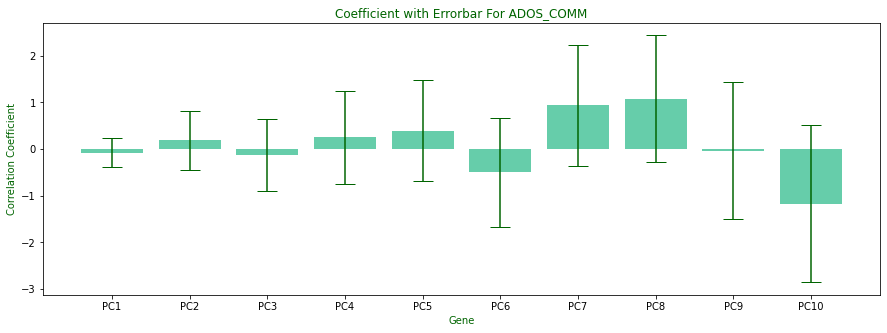

In [98]:
plot_errorbar_from_table(est2_comm,labels)
plt.title('Coefficient with Errorbar For ADOS_COMM',color='darkgreen')
plt.ylabel('Correlation Coefficient',color='darkgreen')
plt.xlabel('Gene',color='darkgreen')

In [99]:
#significance of coefficients for ados_social
print('ADOS_SOCIAL')
X_social = X_use_social.copy()
Y_social = Y_use_social.copy()
X_social = sm.add_constant(X_social)

est_social = sm.OLS(Y_social, X_social)
est2_social = est_social.fit()
print(est2_social.summary())

ADOS_SOCIAL
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.181
Date:                Mon, 28 Nov 2022   Prob (F-statistic):              0.302
Time:                        21:40:53   Log-Likelihood:                -992.28
No. Observations:                 412   AIC:                             2007.
Df Residuals:                     401   BIC:                             2051.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.5461      0.135     55.

In [104]:
def plot_errorbar_from_table(est2_social,labels):
    coef_social = est2_social.params[1::]
    ci_social = est2_social.conf_int()[1::,:]
    ci_rel_social = abs(np.vstack((coef_social,coef_social)).transpose() - ci_social)
    ci_rel_social = ci_rel_social.transpose()
    xs_social = np.arange(len(coef_social))

    plt.figure(figsize=(15,5))
    plt.bar(xs_social,coef_social,color='palevioletred')
    plt.errorbar(xs_social,coef_social,ci_rel_social,fmt='r ',capsize=10,ecolor='darkred')
    plt.xticks(xs_social,labels=labels);

Text(0.5, 0, 'Gene')

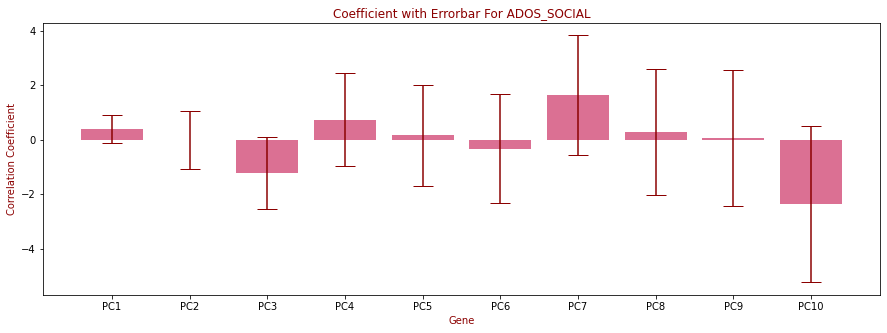

In [106]:
plot_errorbar_from_table(est2_social,labels)
plt.title('Coefficient with Errorbar For ADOS_SOCIAL',color='darkred')
plt.ylabel('Correlation Coefficient',color='darkred')
plt.xlabel('Gene',color='darkred')

In [107]:
#significance of coefficients for ados_rrb
print('ADOS_RRB')
X_rrb = X_use_rrb.copy()
Y_rrb = Y_use_rrb.copy()
X_rrb = sm.add_constant(X_rrb)

est_rrb = sm.OLS(Y_rrb, X_rrb)
est2_rrb = est_rrb.fit()
print(est2_rrb.summary())

ADOS_RRB
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     1.648
Date:                Mon, 28 Nov 2022   Prob (F-statistic):             0.0915
Time:                        21:41:38   Log-Likelihood:                -682.95
No. Observations:                 375   AIC:                             1388.
Df Residuals:                     364   BIC:                             1431.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8490      0.080     23.192

In [112]:
def plot_errorbar_from_table(est2_rrb,labels):
    coef_rrb = est2_rrb.params[1::]
    ci_rrb = est2_rrb.conf_int()[1::,:]
    ci_rel_rrb = abs(np.vstack((coef_rrb,coef_rrb)).transpose() - ci_rrb)
    ci_rel_rrb = ci_rel_rrb.transpose()
    xs_rrb = np.arange(len(coef_rrb))

    plt.figure(figsize=(15,5))
    plt.bar(xs_rrb,coef_rrb,color='peachpuff')
    plt.errorbar(xs_rrb,coef_rrb,ci_rel_rrb,fmt='r ',capsize=10,ecolor='chocolate')
    plt.xticks(xs_rrb,labels=labels);

Text(0.5, 0, 'Gene')

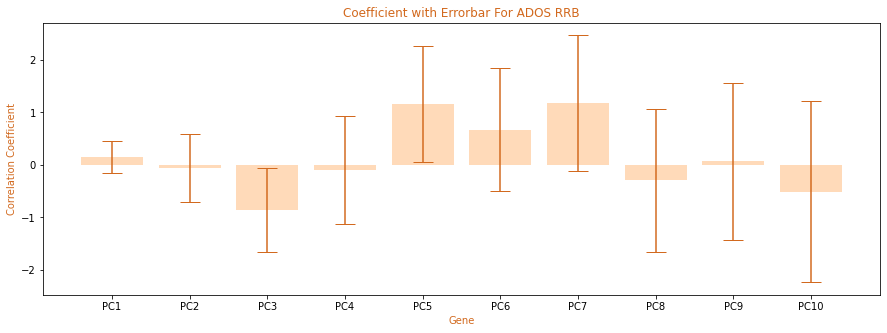

In [114]:
plot_errorbar_from_table(est2_rrb,labels)
plt.title('Coefficient with Errorbar For ADOS RRB',color='chocolate')
plt.ylabel('Correlation Coefficient',color='chocolate')
plt.xlabel('Gene',color='chocolate')